<a href="https://colab.research.google.com/github/swetasrng/swetasrng/blob/main/LSTM_model_for_ethereum_data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# Load the dataset
df = pd.read_csv('Ethereum_Data.csv')


In [6]:
# Drop unnecessary columns
df = df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)

In [7]:
# Set the date as the index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')


In [9]:
# Preprocess the data
df['Price'] = df['Price'].str.replace(',', '').astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)


In [10]:
training_data_len = int(np.ceil(len(df) * 0.8))
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [12]:
# Train the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)


1452/1452 [==============================] - 51s 32ms/step - loss: 2.8598e-04


In [21]:
# Split the data into training and testing sets
train_data = scaled_data[:training_data_len, :]
x_train = []
y_train = []

n_steps = 240 # consider the last 240 days for predicting the price of the next day

for i in range(n_steps, len(train_data)):
    x_train.append(train_data[i - n_steps:i, :])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

test_data = scaled_data[training_data_len - n_steps:, :]
x_test = []
y_test = df[training_data_len:]['Price'].values

for i in range(n_steps, len(test_data)):
    x_test.append(test_data[i - n_steps:i, :])

x_test = np.array(x_test)

# Reset the index of the training and testing dataframes
df_train = df[:training_data_len].reset_index(drop=True)
df_test = df[training_data_len:].reset_index(drop=True)


In [22]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


12/12 [==============================] - 2s 66ms/step


<ipython-input-23-e409f13b8881>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


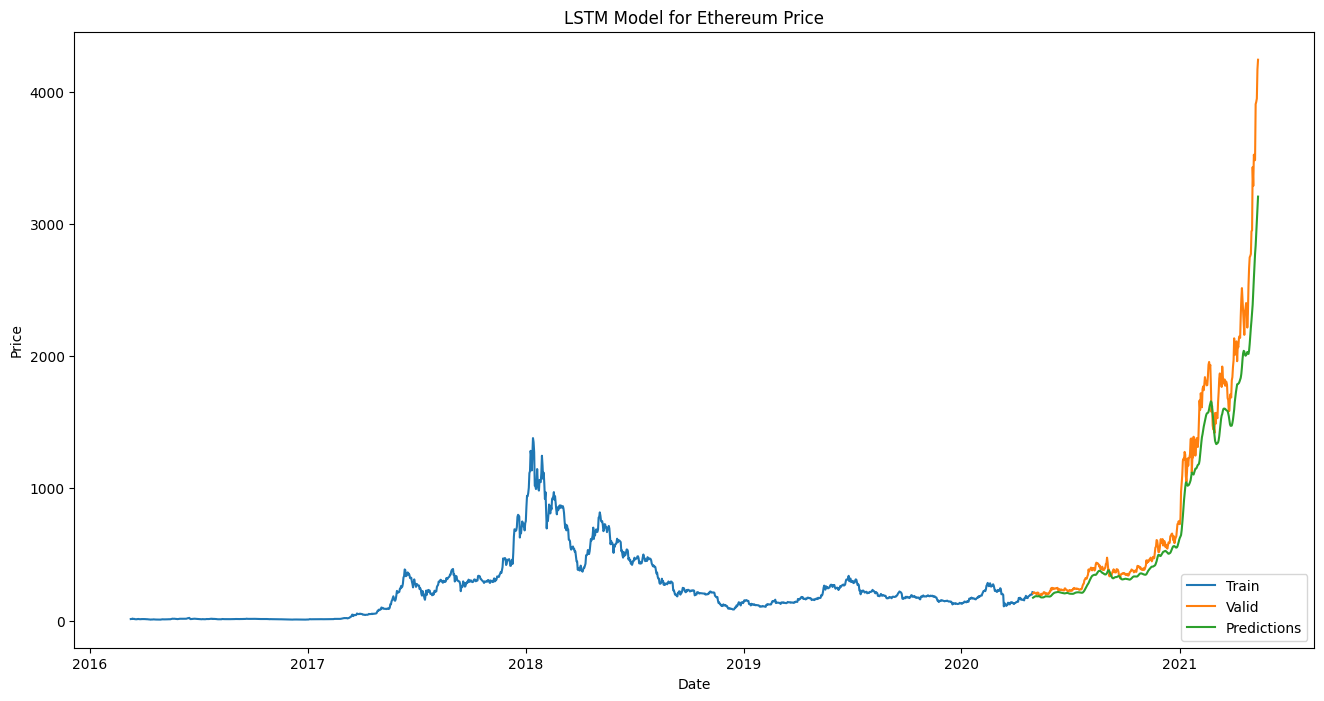

In [23]:
# Visualize the results
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('LSTM Model for Ethereum Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [24]:
# Evaluate the model
mse = model.evaluate(x_test, y_test)

# Print the MSE
print("MSE:", mse)


12/12 [==============================] - 2s 99ms/step - loss: 1523820.7500
MSE: 1523820.75


In [25]:
import math

# Calculate the RMSE
rmse = math.sqrt(mse)

# Print the RMSE
print("RMSE:", rmse)


RMSE: 1234.4313468152047
